In [77]:
from matplotlib.offsetbox import AnchoredText
from scipy.stats import chi2_contingency

from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

In [78]:
#plot out the change in average treatment effect on decisions and outcomes 

def stat_test(ds, val):
    '''
    Calculate p-value of treatment effect. 
    
    '''
    ds = ds.copy()

    if val == "dcorr":
     ds = ds[ds["D_corr"] != "U"]
    
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    if val == "y":
     ctrl_y = base[base["Y"]==1]
     ctrl_noty = base[base["Y"]==0]
     treat_y = variant[variant["Y"]==1]
     treat_noty = variant[variant["Y"]==0]

    if val == "d":
     ctrl_y = base[base["D"]==1]
     ctrl_noty = base[base["D"]==0]
     treat_y = variant[variant["D"]==1]
     treat_noty = variant[variant["D"]==0] 

    if val == "dcorr":
     ctrl_y = base[base["D_corr"]=="1.0"]
     ctrl_noty = base[base["D_corr"]=="0.0"]
     treat_y = variant[variant["D_corr"]=="1.0"]
     treat_noty = variant[variant["D_corr"]=="0.0"]   

    ty = treat_y.shape[0]
    cy = ctrl_y.shape[0]
    t_not = treat_noty.shape[0]
    c_not =ctrl_noty.shape[0]
    
    obs = np.array([[ty, cy], [t_not, c_not]])

    _, p, _, _ = chi2_contingency(obs, lambda_="log-likelihood")

    return p, obs

def estimate_uplift_y(ds):
    """
    Estiamte the difference in means between two groups.
 
    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals arround "estimated_effect"
        
        
    """
    ds = ds.copy()
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant["Y"].mean() - base["Y"].mean()
    delta_err = 1.96 * np.sqrt(
        variant["Y"].var() / variant.shape[0] + 
        base["Y"].var() / base.shape[0])
    
    return delta,delta_err 

def estimate_uplift_d(ds, D_ref):
    """
    Estiamte the difference in means between two groups.
    
    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals around "estimated_effect" 
        
    """
    ds = ds.copy()
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant[D_ref].mean() - base[D_ref].mean()
    delta_err = 1.96 * np.sqrt(
        variant[D_ref].var() / variant.shape[0] + 
        base[D_ref].var() / base.shape[0])
    
    return delta,delta_err #{"estimated_effect_d_overall": delta, "standard_error_d_overall": delta_err}

def estimate_uplift_dcorrect(ds):
    """
    Estimate the difference in means between two groups.

    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals around "estimated_effect"
        
    """
    ds = ds.copy()
    
    ds = ds[ds["D_corr"] != "U"] #Remove examples we don't know the correctness of the outcome for 
    
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant["D_corr"].astype("float").mean() - base["D_corr"].astype("float").mean()
    delta_err = 1.96 * np.sqrt(
        variant["D_corr"].astype("float").var() / variant.shape[0] + 
        base["D_corr"].astype("float").var() / base.shape[0])
    
    return delta,delta_err 

#Note -- break this down by demographic [M, F, W, NW, WM, NWM, WF, NWF]

def demo_est(ds, D_ref):
    '''
    Break down average treatment effect by demographic [M, F, W, NW, WM, NWM, WF, NWF]
    '''
    
    demo = {"M":{"Sex":[1], "White": [0,1]}, "F":{"Sex":[0], "White": [0,1]}, "W":{"Sex":[0,1], "White": [1]}, "NW":{"Sex":[0,1], "White": [0]}, "WM":{"Sex":[1], "White": [1]}, "NWM":{"Sex":[1], "White": [0]}, "WF":{"Sex":[0], "White": [1]}, "NWF":{"Sex":[0], "White": [0]}}
    
    res_dict = dict()
    for item in demo:
        ds_demo = ds.copy()
        print(item)
        ds_demo = ds_demo[ds_demo["Sex"].isin(demo[item]["Sex"])]
        ds_demo = ds_demo[ds_demo["White"].isin(demo[item]["White"])]

        res_dict[item] = [estimate_uplift_y(ds_demo), estimate_uplift_d(ds_demo, D_ref), estimate_uplift_dcorrect(ds_demo)]
        
    return res_dict



def get_res(df, D_ref):
    df = df.copy()
    
    res = demo_est(df, D_ref)
    res["Overall"]=[estimate_uplift_y(df), estimate_uplift_d(df, D_ref), estimate_uplift_dcorrect(df)]

    return res


In [79]:
effect_index ={"y":[0, "estimated_effect_y", "Outcomes"], "d": [1, "Decisions", "estimated_effect_d"] , "dcorr": [2, "Decision Correctness", "estimated_effect_dcorr"]}

exp1_folder = "Results/Experiment_1"
exp2_folder = "Results/Experiment_2" 
exp3_folder = "Results/Experiment_3"

In [87]:
import matplotlib.pyplot as plt

effects = effect_index.keys()

def plot_res(exp_folder, effect="d" , linear=True, trial_num=1000, j_filter=None, filter=None): 

    a_list = list()
    b_list = list()
    c_list = list()
    l = list()
    res_list = list()

    #print("hi")
    for file in os.listdir(exp_folder):
        print(file, effect_index[effect][2])

        if "exp" not in file:
            continue
        if "table" in file:
            continue
            
        f_details = file.strip(".csv").split("_")
        print(f_details)

        
        t_idx = [i for i in range(len(f_details)) if re.search("t", f_details[i])][0]#f_details.
        num_t = int(f_details[t_idx].strip("t")) #number of trials 
        
        exp_num = int(f_details[1][-1])
        exp_idx = "D_"+f_details[1]

        sum_idx = [i for i in range(len(f_details)) if re.search("summary", f_details[i])][0] 

        if trial_num != num_t:
            continue

        if linear:
            if "_non_linear" in file:
                continue 
        else:
            if "_non_linear" not in file:
                continue 

        if filter:
            if filter not in file:
                continue 
        
        
        if j_filter and exp_idx != "D_exp1":
            print("WAIT", j_filter)
            if j_filter not in file:
                continue 
                
        j=""
        for i in range(0, len(f_details[sum_idx+1: t_idx])):
            j += "J%d=%s,"%(i+1, f_details[sum_idx+1: t_idx][i])
        
        df = pd.read_csv(exp_folder+"/"+file)
        res = get_res(df, exp_idx)
        res_p = stat_test(df, effect)
    
        a = res.keys()
        b = list()
        c = list()
    
    
        idx = effect_index[effect][0] 
        for k in res.keys():
            b.append(res[k][idx][0])
            c.append(res[k][idx][1])

        print(a, b, c)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c) 

        if exp_idx == "D_exp3" or exp_idx == "D_exp2":
            idx = -1
            if filter:
                idx -= 1
            if linear:
                l.append(float(f_details[idx]))
            else:
                idx -=2
                l.append(float(f_details[idx]))
            j = j 
            
        else:
            l.append(j)
            j = None 

        df_res = res 
        res_list.append(df_res)
        
    return a_list, b_list, c_list, l, res_list, effect, j



D_exp3_summary_0.6_0.1_0.3_t100_bk=0.6_thres=0.15_0.4_alt.csv estimated_effect_d
['D', 'exp3', 'summary', '0.6', '0.1', '0.3', 't100', 'bk=0.6', 'thres=0.15', '0.4', 'alt']
D_exp3_summary_0.6_0.1_0.3_t100_bk=0.6_thres=0.15_0.8_non_linear_alt.csv estimated_effect_d
['D', 'exp3', 'summary', '0.6', '0.1', '0.3', 't100', 'bk=0.6', 'thres=0.15', '0.8', 'non', 'linear', 'alt']
WAIT _0.333_0.333_0.333_
D_exp3_summary_0.6_0.1_0.3_t10_0.2_non_linear.csv estimated_effect_d
['D', 'exp3', 'summary', '0.6', '0.1', '0.3', 't10', '0.2', 'non', 'linear']
D_exp3_summary_0.333_0.333_0.333_t10_0.9_non_linear_test.csv estimated_effect_d
['D', 'exp3', 'summary', '0.333', '0.333', '0.333', 't10', '0.9', 'non', 'linear', 'test']
D_exp3_summary_0.6_0.1_0.3_t1000_0.7.csv estimated_effect_d
['D', 'exp3', 'summary', '0.6', '0.1', '0.3', 't1000', '0.7']
D_exp3_summary_0.6_0.1_0.3_t1000_0.2_non_linear.csv estimated_effect_d
['D', 'exp3', 'summary', '0.6', '0.1', '0.3', 't1000', '0.2', 'non', 'linear']
D_exp3_summa

/var/folders/n5/2xnc13kx64j0nynmy8zwv2680000gn/T/ipykernel_76423/216978970.py:62: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(a_list[i], b_list[i], yerr=c_list[i], color="red", fmt="o", label=l[i], marker=symbol_set[i])
/var/folders/n5/2xnc13kx64j0nynmy8zwv2680000gn/T/ipykernel_76423/216978970.py:65: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(a_list[i], b_list[i], yerr=c_list[i], fmt="o", label=l[i], marker=symbol_set[i])


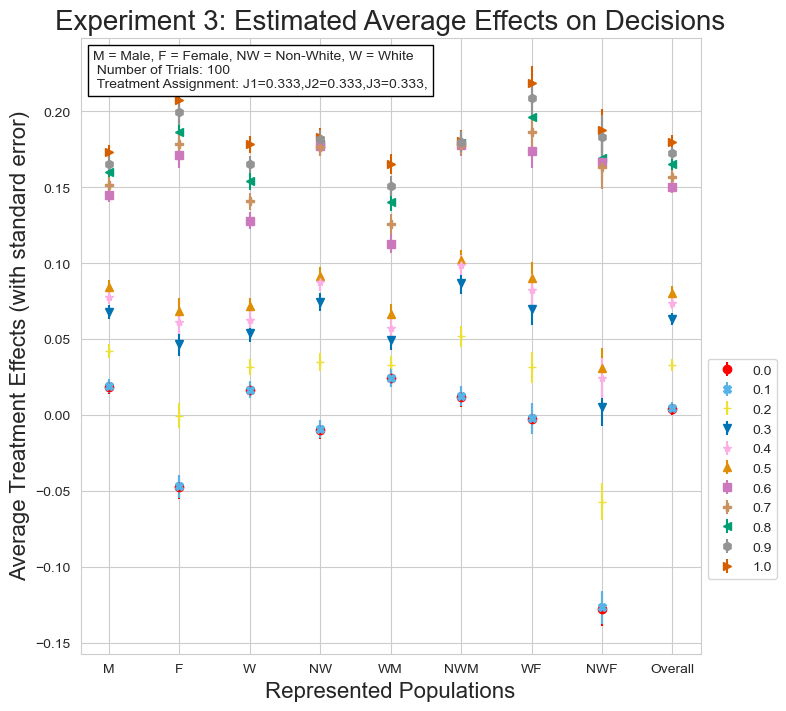

In [196]:
exp_num = 3
num_t = 100 
cases = ["_0.6_0.1_0.3_","_0.999999999_1e-07_", "_0.5_0.5_", "_0.333_0.333_0.333_"]
j_f = cases[3]
b_k = 0.6
thres = 0.15
f = "bk="+str(b_k)+"_thres="+str(thres) #None #"alt"

a_list, b_list, c_list, l, res_list, effect, j = plot_res(exp3_folder,j_filter=j_f, trial_num=num_t, linear=False, filter=f, effect="d")


fig, ax = plt.subplots(figsize=(8, 8))

hatchings = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
symbols = {
    #'point': '.',
    #'pixel': ',',
    'circle': 'o',
    'triangle_down': 'v',
    'triangle_up': '^',
    'triangle_left': '<',
    'triangle_right': '>',
    #'tri_down': '1',
    #'tri_up': '2',
    #'tri_left': '3',
    #'tri_right': '4',
    #'octagon': '8',
    'square': 's',
    #'pentagon': 'p',
    'plus (filled)': 'P',
    'star': '*',
    'hexagon1': 'h',
    #'hexagon2': 'H',
    'plus': '+',
    #'x': 'x',
    'x (filled)': 'X',
    'diamond': 'D',
    #'thin_diamond': 'd',
    #'vline': '|',
   # 'hline': '_',
    #'tickleft': 0,
    #'tickright': 1,
    #'tickup': 2,
    #'tickdown': 3,
    #'caretleft (centred)': 4,
    #'caretright (centred)': 5,
    #'caretup (centred)': 6,
    #'caretdown (centred)': 7,
    #'caretleft': 8,
    #'caretright': 9,
    #'caretup': 10,
    #'caretdown': 11,
    #'nothing': '',
    #'mathtext': '$f$',
}
symbol_set = list(symbols.values())

for item in l:
    i = l.index(item)
    print(i)
    if i == 0.0:
        ax.errorbar(a_list[i], b_list[i], yerr=c_list[i], color="red", fmt="o", label=l[i], marker=symbol_set[i])
    else:
        print(i)
        ax.errorbar(a_list[i], b_list[i], yerr=c_list[i], fmt="o", label=l[i], marker=symbol_set[i])

plt.title("Experiment %d: Estimated Average Effects on %s"%(exp_num, effect_index[effect][1]), fontsize=20)
plt.xlabel("Represented Populations", fontsize=16)
plt.ylabel("Average Treatment Effects (with standard error)", fontsize=16)

if exp_num == 1:
    anch_text = "M = Male, F = Female, NW = Non-White, W = White \n Number of Trials: %d"%(num_t)
else:
    anch_text = "M = Male, F = Female, NW = Non-White, W = White \n Number of Trials: %d \n Treatment Assignment: %s"%(num_t, j)

at = AnchoredText(anch_text,
                  prop=dict(size=10), frameon=True, loc='upper left')


# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the legend elements
order = list()
idx_ref = list(enumerate(l))
for item in sorted(l):
    for item2 in idx_ref:
        if item == item2[1]:
            order.append(item2[0])
            
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order],loc='center left', bbox_to_anchor=(1, 0.3))

ax.add_artist(at)
plt.savefig('Figs/non_linear_Exp%d_%s_%s%d_%s.png'%(exp_num,effect_index[effect][1],j_f,num_t,f), bbox_inches='tight')

In [76]:
for res in res_list:
    df = pd.DataFrame(res, index=list([elem[1] for elem in effect_index.values()]))
    #df.index.names = list([elem[1] for elem in effect_index.values()])
    latex_table = df.to_latex(index=False)
    print(latex_table)

\begin{tabular}{lllllllll}
\toprule
M & F & W & NW & WM & NWM & WF & NWF & Overall \\
\midrule
(0.019157274258323642, 0.0015877896607827233) & (-0.0884353741496598, 0.003078409808152324) & (-0.013174428962270168, 0.0019310893315110343) & (0.008355019860293134, 0.0020701564966673024) & (0.00534009046741496, 0.00221106210846246) & (0.032965074839629405, 0.002275435676345182) & (-0.07686691005642216, 0.003940542638852113) & (-0.10891256553357015, 0.004945299718837548) & (-0.0033536026059214907, 0.0014129036130673314) \\
(0.042478715939024914, 0.0014475857413260983) & (-0.006247398959583844, 0.0025076706541765797) & (0.03926512693262077, 0.0017006041078646498) & (0.023513795674869498, 0.0018767705124477702) & (0.04264986457809794, 0.0019811414098875164) & (0.041875623663578054, 0.0021097438940757885) & (0.03291503484898772, 0.0033000130613587988) & (-0.07634229663453407, 0.003735474886865471) & (0.031592900832695725, 0.0012620045647662144) \\
(0.047046773218373805, 0.001877481823505467) & 